## Часть 0. Подготовка

In [1]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

** Задание 1 **

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

In [3]:
# Загружаем обучающую выборку
df = pd.read_csv('train.csv')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
len(df)

1458644

In [4]:
# Удалим колонку dropoff_datetime и pickup_datetime преобразуем в datetime-объект
df = df.drop(columns = 'dropoff_datetime')
df["pickup_datetime"] = pd.to_datetime(df.pickup_datetime)
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Text(0.5,1,'Распределение длительности поездкок в секундах')

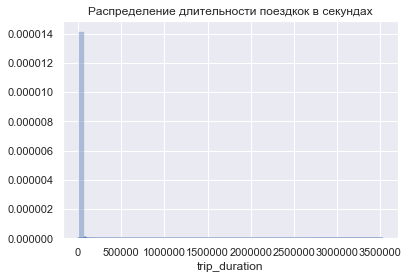

In [5]:
# Построим гистограмму по имеющимся данным
sns.distplot(df.trip_duration)
plt.title('Распределение длительности поездкок в секундах')

Text(0.5,1,'Распределение длительности поездкок в минутах (для trip_duration < 1 часа)')

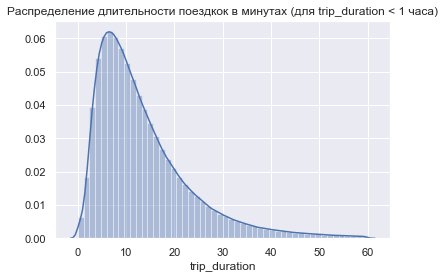

In [6]:
# Нарисуем более наглядную гистограмму для понимания картины длительности поездок
sns.distplot(df[df.trip_duration < 3600].trip_duration/60)
plt.title('Распределение длительности поездкок в минутах (для trip_duration < 1 часа)')

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

Видим, целевая переменная имеет распределение с тяжелыми хвостами и похоже, там довольно много выбросов

** Вопрос: ** Почему авторы соревнования выбрали именно RMSLE, а не RMSE?

1) Логарифмирование помогает распределение величин с тяжелыми хвостами аппроксимировать ближе к нормальному, что также означает, что выбросов станет меньше

2) За одни и те же абсолютые значения расхождений больше штрафует при меньших значениях предсказаний, чем при больших. 

Например: расхождение между 10 и 20 минутами поездки выглядит куда критичнее, нежели между 50 и 60 минутами, что в RMSE было бы идентично, но учтется в RMSLE:
- ln(61) - ln(51) << ln(21) - ln(10)
- 60 - 50 == 20 -10

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: В случае взятия производной, у каждой из вышеуказанных функций оптимизации минимумы сойдутся в y среднем

In [7]:
# Добавим к нашей выборке колонку log_trip_duration 
df['log_trip_duration'] = np.log1p(df.trip_duration)

Text(0.5,1,'Распределение логарифма длительности поездкок в секундах')

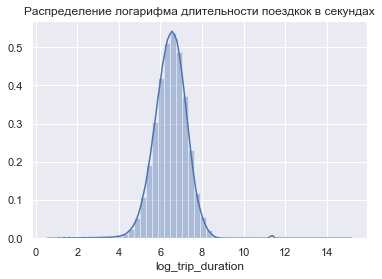

In [8]:
# Нарисуем гистограмму модифицированного таргета по обучающей выборке
sns.distplot(df.log_trip_duration)
plt.title('Распределение логарифма длительности поездкок в секундах')

In [9]:
# Удалим колонку со старым таргетом
df = df.drop(columns = 'trip_duration')

In [10]:
# Посчитаем значение метрики при наилучшем константном предсказании
from sklearn.metrics import mean_squared_error

ndf = df.copy()
ndf['mean']=df.log_trip_duration.mean()
y_true = ndf['mean']
y_pred = df.log_trip_duration
print('RMSE =',mean_squared_error(y_true, y_pred, squared=False))
print('MSE =',mean_squared_error(y_true, y_pred))

RMSE = 0.7957592365411504
MSE = 0.6332327625405546


## Часть 1. Изучаем pickup_datetime

** Задание 2 **

Text(0.5,1,'Зависимость количества поездок от дня в году')

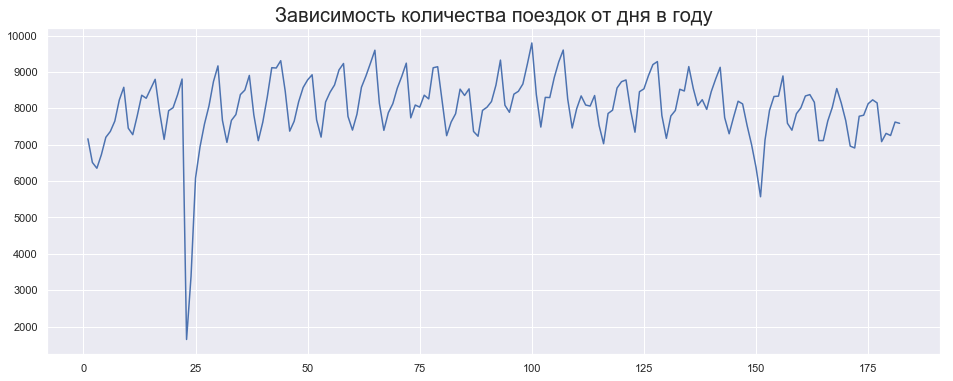

In [11]:
# Построим график зависимости количества поездок от дня в году, подготовив перед этим данные

df2 = df.copy()
df2['dayofyear']=df.pickup_datetime.dt.dayofyear

counts = pd.DataFrame([])
counts['id'] = df2.groupby(by=['dayofyear'], as_index=False).count().id
counts['dayofyear'] = df2.groupby(by=['dayofyear'], as_index=False).count().dayofyear

plt.figure(figsize=(16, 6))
plt.plot(counts['dayofyear'],counts['id'])
plt.title('Зависимость количества поездок от дня в году', fontsize = 20)

In [12]:
df[['id','pickup_datetime']].groupby(df.pickup_datetime.dt.dayofyear).count().nsmallest(3, 'id')


,id,pickup_datetime
pickup_datetime,,
23,1648,1648
24,3383,3383
151,5570,5570


In [13]:
# Периоды спада
print(max(df[df.pickup_datetime.dt.dayofyear==23].pickup_datetime.dt.date))
print(max(df[df.pickup_datetime.dt.dayofyear==151].pickup_datetime.dt.date))

2016-01-23
2016-05-30


**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.
    
1й спад: 23-24 января 2016го. Причина: 
- снежная буря, метель - аномальная погода для города

2й спад: 30го мая 2016го. Причина: 
- выходной день в честь праздника "День поминовения"

In [14]:
# Создадим новые поля и таблицы с группировкой по ним, посчитав число заказов
df2['hour']=df.pickup_datetime.dt.hour
df2['dayofweek']=df.pickup_datetime.dt.dayofweek

# Для дней недели:
new_table = df2[['dayofweek','id']].groupby(by=["dayofweek"], as_index=False).count()

# Для часов в сутках:
new_table2 = df2[['hour','id']].groupby(by="hour", as_index=False).count()


Text(0.5,1,'Зависимость количества поездок от дня недели')

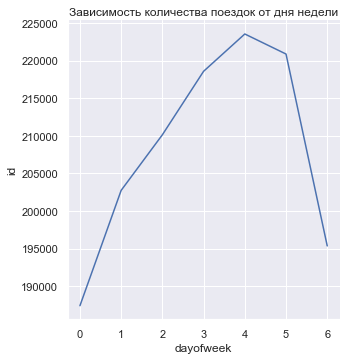

In [15]:
# Нарисуем графики зависимости количества поездок от дня недели и от часов в сутках
# 0 - понедельник
sns.relplot(data=new_table, x="dayofweek", y="id", kind="line")
plt.title('Зависимость количества поездок от дня недели')

Text(0.5,1,'Зависимость количества поездок от часа в сутках')

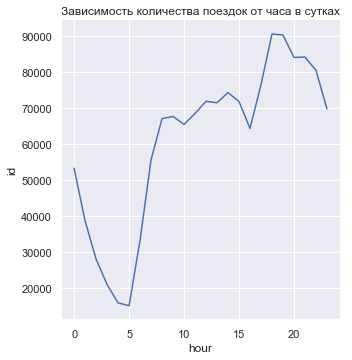

In [16]:
sns.relplot(data=new_table2, x="hour", y="id", kind="line")
plt.title('Зависимость количества поездок от часа в сутках')

**Задание 3 **

In [17]:
df2['month']=df.pickup_datetime.dt.month
new_table3 = df2[['hour','month','id']].groupby(by=['hour','month'], as_index=False).count()
new_table4 = df2[['hour','dayofweek','id']].groupby(by=['hour','dayofweek'], as_index=False).count()


Text(0.5,1,'Зависимость количества поездок от часа в сутках для разных месяцев')

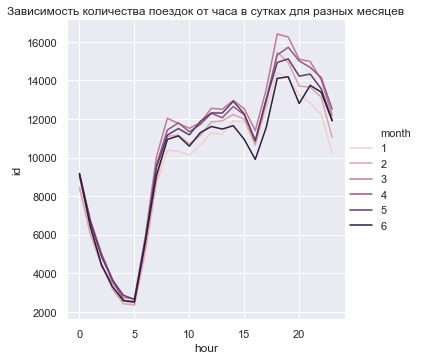

In [18]:
sns.relplot(data=new_table3, x="hour", y="id", hue="month", kind="line", legend="full")
plt.title('Зависимость количества поездок от часа в сутках для разных месяцев')

Text(0.5,1,'Зависимость количества поездок от часа в сутках для разных дней недели')

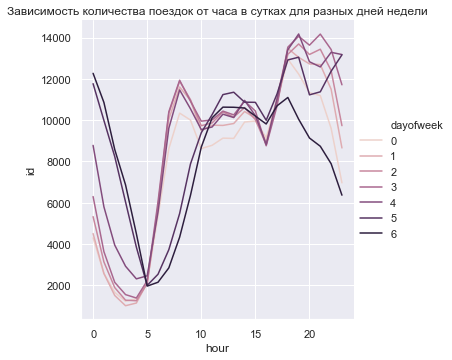

In [19]:
sns.relplot(data=new_table4, x="hour", y="id", hue="dayofweek", kind="line", legend="full")
plt.title('Зависимость количества поездок от часа в сутках для разных дней недели')

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

Будние дни (пн-пт): в 1-7 часов все в основном спят, поэтому поездок значительно меньше, в 8-10 часов - все просыпаются и едут по своим дела, 18-20 - самый пик, когда люди возвращаются с работы/своих дел

Выходные (сб-вс) же наоборот - пик поездок приходится на ночное время (уже с пятницы можно увидеть начала роста поездок в ночное время), что можно связать с досугом


**Задание 4**

In [90]:
#Разобьем выборку на обучающую и тестовую в отношении 7:3
from sklearn.model_selection import train_test_split

train, test, = train_test_split(df, test_size=0.3, random_state=10)

Text(0.5,1,'Зависимость среднего логарифма времени поездки от дня в году')

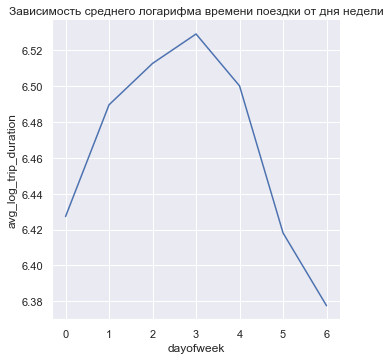

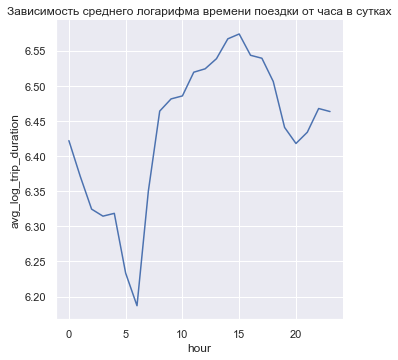

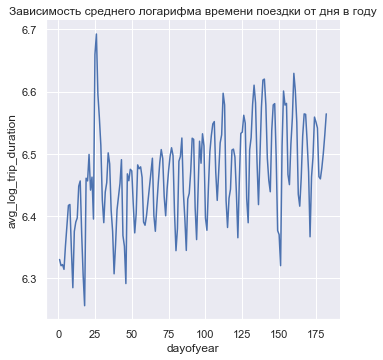

In [91]:
# По обучающей выборке нарисуем график зависимости среднего логарифма времени поездки от 
# 1) дня недели, 2) часа в сутках и 3) дня в году

# Создадим новые поля и таблицы с группировкой по ним, посчитав число заказов
train['dayofweek']=train.pickup_datetime.dt.dayofweek
train['hour']=train.pickup_datetime.dt.hour
train['dayofyear']=train.pickup_datetime.dt.dayofyear
train1 = pd.DataFrame([])
train2 = pd.DataFrame([])
train3 = pd.DataFrame([])

# Для дней недели:
train1['avg_log_trip_duration'] = train.groupby(by=['dayofweek'], as_index=False).mean().log_trip_duration
train1['dayofweek'] = train.groupby(by=['dayofweek'], as_index=False).mean().dayofweek

# Для часов в сутках:
train2['avg_log_trip_duration'] = train.groupby(by=['hour'], as_index=False).mean().log_trip_duration
train2['hour'] = train.groupby(by=['hour'], as_index=False).mean().hour

# Для дня в году:
train3['avg_log_trip_duration'] = train.groupby(by=['dayofyear'], as_index=False).mean().log_trip_duration
train3['dayofyear'] = train.groupby(by=['dayofyear'], as_index=False).mean().dayofyear

sns.relplot(data=train1, x='dayofweek',y='avg_log_trip_duration', kind="line")
plt.title('Зависимость среднего логарифма времени поездки от дня недели')

sns.relplot(data=train2, x='hour',y='avg_log_trip_duration', kind="line")
plt.title('Зависимость среднего логарифма времени поездки от часа в сутках')

sns.relplot(data=train3, x='dayofyear',y='avg_log_trip_duration', kind="line")
plt.title('Зависимость среднего логарифма времени поездки от дня в году')


**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости log_trip_duration от номера дня в году?

- Да, графики среднего логарифма продолжительности поездки и числа поездок достаточно похожи между собой форме: практически один характер роста/спада в зависимости от часа/дня недели


- Скорее всего, причина в том, что в пиковое время наблюдаются пробки на дорогах (тем более, это Нью-Йорк) и фактическая продолжительность поездки увеличивается

In [97]:
# 1й аномальный период
train3[(train3.dayofyear==23)|(train3.dayofyear==24)]

,avg_log_trip_duration,dayofyear
22,6.462632,23
23,6.395267,24


In [93]:
# 2й аномальный период
train3[train3.dayofyear==151]

,avg_log_trip_duration,dayofyear
150,6.320422,151


- В первый аномальный период (23-24 января) средний таргет выглядит +- типично, хоть по логике описанной выше, он должен был просесть, ведь машин на дорогах должно было быть немного. Скорее всего, было дело в сильном снегопаде, который замедлил движение транспорта, что нейтрализовало эффект отсутствия машин на дорогах


- Во втором аномальном периоде (30 мая) все сходится и на обновленном таргете видим падение: скорее всего, в праздник жители не планировали особых продолжительных поездок или просто машин на улицах было немного


- На графике зависимости log_trip_duration от номера дня в году наблюдается тренд возврастания продолжительности поездок, что может объясняться усугублением ситуации на дорогах (гипотеза о большем доверии к сервису для совершения более продолжительных поездок отвергается, ведь у числа поездок такого тренда не обнаружено)

Добавим следующие признаки на основе pickup_datetime:

- День недели
- Месяц
- Час
- Является ли период аномальным (True для 23-24 и 151 дней)
- Номер дня в году

In [101]:
# dayofweek, hour и dayofyear добавлены ранее
#  Зададим month и anomaly:
train['month'] = train.pickup_datetime.dt.month
train['anomaly'] = ((train.dayofyear == 23) | (train.dayofyear == 24) | (train.dayofyear == 151)).replace([True, False], [1, 0])

train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,dayofweek,hour,dayofyear,month,anomaly
824746,id2365163,2,2016-03-27 00:25:29,3,-73.996986,40.742210,-73.987740,40.710659,N,7.134891,6,0,87,3,0
645821,id3126187,2,2016-03-18 20:44:12,1,-73.989929,40.741760,-73.977280,40.783600,N,6.878326,4,20,78,3,0
691846,id2588127,2,2016-04-15 18:26:12,2,-73.972366,40.750725,-73.861832,40.768387,N,7.642524,4,18,106,4,0
1147931,id0915715,2,2016-03-24 14:28:34,1,-73.982361,40.776901,-73.975128,40.760921,N,6.888572,3,14,84,3,0
183569,id3758776,1,2016-04-28 13:53:52,1,-73.973778,40.764374,-73.966957,40.761024,N,6.177944,3,13,119,4,0


Text(0.5,1,'Зависимость среднего логарифма времени поездки от месяца')

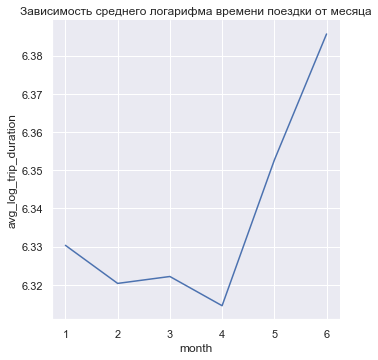

In [25]:
# Посмотрим на зависимость продолжительности поездок от месяца
train4 = pd.DataFrame([])
train4['avg_log_trip_duration'] = train.groupby(by=['dayofyear'], as_index=False).mean().log_trip_duration
train4['month'] = train.groupby(by=['month'], as_index=False).mean().month

sns.relplot(data=train4, x='month',y='avg_log_trip_duration', kind="line")
plt.title('Зависимость среднего логарифма времени поездки от месяца')

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

Среди введенных признаков стоит рассматривать как категориальные следующие:
- День недели
- Месяц
- Час
- Является ли период аномальным

Вышеуказанные признаки относим к категориальным по 2м причинам: отсутствует линейная зависимость, а также их значения ограничены (7 дней недели, 12 месяцев и 24 часа в сутках, 0 и 1 для аномалии)

К числовым:
- Номер дня в году, т.к. наблюдаем линейную зависимость

**Задание 5** 

In [102]:
# Добавим в тестовую выборку новые признаки
test['dayofweek'] = test.pickup_datetime.dt.dayofweek
test['hour'] = test.pickup_datetime.dt.hour
test['dayofyear'] = test.pickup_datetime.dt.dayofyear
test['month'] = test.pickup_datetime.dt.month
test['anomaly'] = ((test.dayofyear == 23) | (test.dayofyear == 24) | (test.dayofyear == 151)).replace([True, False], [1, 0])

# Начнем обучать модель
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical = ['hour','dayofweek','month','anomaly']
numeric_features = ['dayofyear']
target = ['log_trip_duration']

X_train = train[categorical+numeric_features]
y_train = train[target]
X_test = test[categorical+numeric_features]
y_test = test[target]

column_transformer = ColumnTransformer([
# One-hot кодирование для категориальных признаков
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical), 
# Масштабирование для числовых
    ('scaling', StandardScaler(), numeric_features) 
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))


Test MSE = 0.6202


## Часть 2. Изучаем координаты

In [27]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [28]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [29]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

Выделяются крупнейшие аэропорты Нью-Йорка: аэропорт имени Джона Кеннеди и Ла-Гвардия

**Задание 6** 

In [104]:
# Воспользуемся кодом с первого семинара,
# чтобы посчитать кратчайшее расстояние для объектов и 
# запишем его в колонку haversine

def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

train.loc[:, 'haversine'] = haversine_array(
    train['pickup_latitude'].values, 
    train['pickup_longitude'].values, 
    train['dropoff_latitude'].values, 
    train['dropoff_longitude'].values
)

Text(0.5,1,'З-ть логарифма длительности поездок от логарифма расстояния')

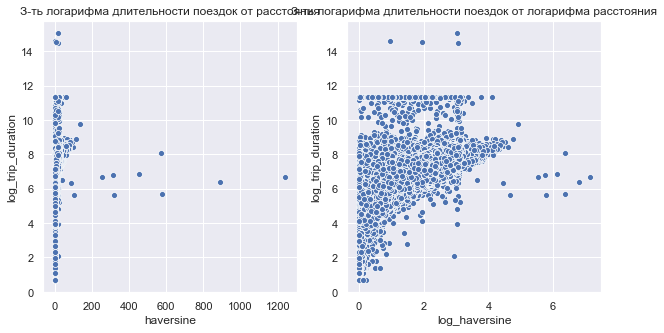

In [105]:
# Вычислим логарифм расстояния и запишем его в отдельную колонку
train['log_haversine'] = np.log1p(train.haversine)

# Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))#, tight_layout=True)
ax1 = sns.scatterplot(data=train, x="haversine", y="log_trip_duration", ax=ax[0])
ax1.set_title('З-ть логарифма длительности поездок от расстояния')
ax2 = sns.scatterplot(data=train, x="log_haversine", y="log_trip_duration", ax=ax[1])
ax2.set_title('З-ть логарифма длительности поездок от логарифма расстояния')

Действительно, правом графике точки по диагонале неплохо выстраиваются в прямую линию

**Задание 7** 

Text(0.5,1,'Распределение средней скорости поездки (км/час)')

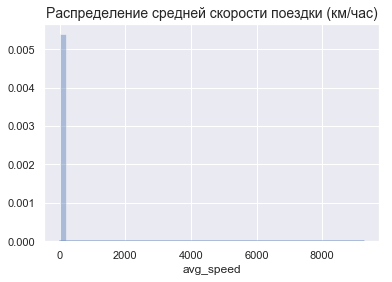

In [106]:
# Посчитаем среднюю скорость для каждого объекта обучающей выборки (км/час)
train['avg_speed'] = train.haversine/(np.expm1(train.log_trip_duration)/3600)

sns.distplot(train.avg_speed)
plt.title('Распределение средней скорости поездки (км/час)', fontsize = 14)

Судя по гистограмме, для части объектов скорость вышла неразумной (что может быть связано с некорректными значениями времени поездки из-за багов таксометра или расстояния из-за cбоя gps)

Нарисуем гистограмму, отсеив скорости выше 120ти км/час (все-таки это такси, а не гонки)

Text(0.5,1,'Распределение средней скорости поездки (км/час)')

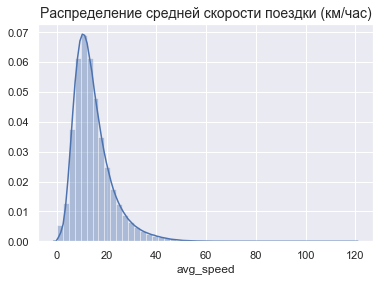

In [107]:
sns.distplot(train[train.avg_speed < 120].avg_speed)
plt.title('Распределение средней скорости поездки (км/час)', fontsize = 14)

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью sns.heatmap график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

Text(0.5,1,'Тепловая карта зависимости медианы скорости (км/час) от часа и дня недели')

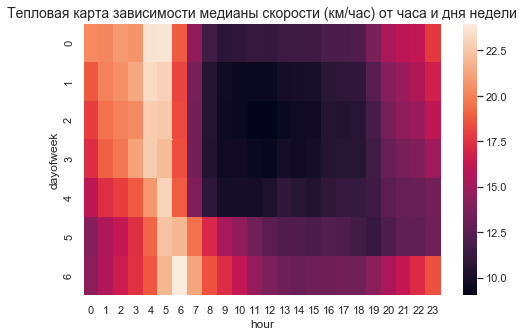

In [34]:
# Для каждой пары (день недели, час суток) посчитаем медиану скоростей (км/час)
median_df = train[['dayofweek','hour','avg_speed']].groupby(
    by=['dayofweek','hour'], as_index=False
).median()

plt.figure(figsize=(8, 5))
sns.heatmap(median_df.pivot('dayofweek','hour','avg_speed'))
plt.title('Тепловая карта зависимости медианы скорости (км/час) от часа и дня недели', fontsize = 14)


**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

Скорость не может быть признаком, т.к. она является производной величиной от расстояния, т.е. если бы мы ее оставили, то столкнулись бы с проблемой переобучения

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна

Судя по графику, скорость максимальна в 6 часов утра в воскресенье (максимально свободные дороги), минимальна - в 11-12 часов в среду (самые критичые пробки)

Для оценки пробок возьмем те пары дней недели + час, для которых медиана скорости менее 10км/час, для оценки свободных дорог - более 20км/час

In [108]:
# Прежде, чем удалять скорость, добавим новую колонку 
# со значениями меиданы скоростей для связки час+день недели
train['median_speed'] = train.groupby(by=['dayofweek','hour']).avg_speed.transform(lambda s: np.median(s.values))

# Будем считать, что поездка совершается в период пробок для тех дней недели и часов, 
# если у них медиана скорости меньше 10 км/час
train['big_traffic'] = (train.median_speed < 10).replace([True, False], [1, 0])

# Будем считать, что поездка совершается в период свободных дорог для тех дней недели и часов, 
# если у них медиана скорости больше 20 км/час
train['free_road'] = (train.median_speed > 20).replace([True, False], [1, 0])


In [109]:
# Удалим колонки со значением скорости и ее медианы для часа/дня недели из данных:
train = train.drop(columns = 'avg_speed')
train = train.drop(columns = 'median_speed')

**Задание 8** (0.25 балла). Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [110]:
airport1_points = [40.646875, -73.791686] #к-ты аэропорта им. Дж. Кеннеди
airport2_points = [40.777241, -73.872700] #к-ты аэропорта Ла-Гвардия

# Будем считать, что поездка началась/завершилась в аэропорту, 
# если расстояние от координат аэропорта до нее менее 1 км
train['pickup_airport1'] = (haversine_array(
    airport1_points[0],airport1_points[1],
    train.pickup_latitude,train.pickup_longitude) < 1).replace([True, False], [1, 0])

train['pickup_airport2'] = (haversine_array(
    airport2_points[0],airport2_points[1],
    train.pickup_latitude,train.pickup_longitude) < 1).replace([True, False], [1, 0])

train['dropoff_airport1'] = (haversine_array(
    airport1_points[0],airport1_points[1],
    train.dropoff_latitude,train.dropoff_longitude) < 1).replace([True, False], [1, 0])

train['dropoff_airport2'] = (haversine_array(
    airport2_points[0],airport2_points[1],
    train.dropoff_latitude,train.dropoff_longitude) < 1).replace([True, False], [1, 0])


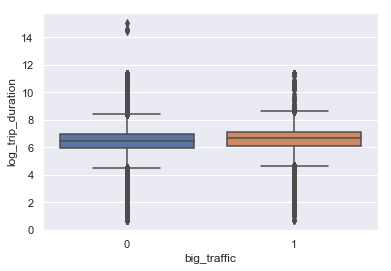

In [111]:
# Нарисуем "ящик с усами" для созданных ранее признаков
sns.boxplot(data=train, x="big_traffic", y="log_trip_duration")

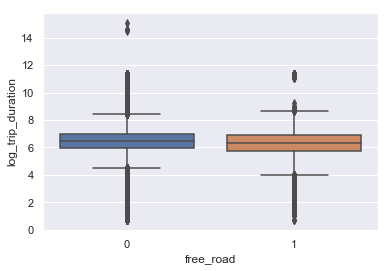

In [112]:
sns.boxplot(data=train, x="free_road", y="log_trip_duration")

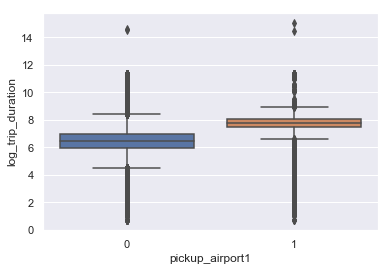

In [113]:
sns.boxplot(data=train, x="pickup_airport1", y="log_trip_duration")

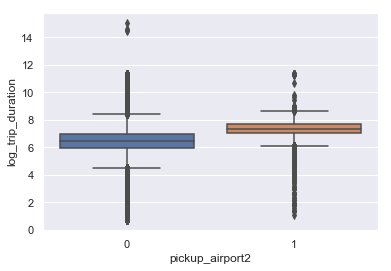

In [114]:
sns.boxplot(data=train, x="pickup_airport2", y="log_trip_duration")

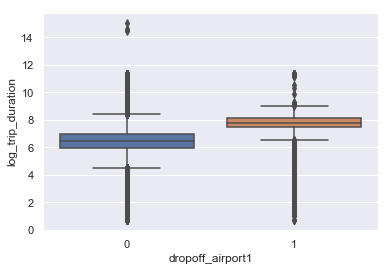

In [115]:
sns.boxplot(data=train, x="dropoff_airport1", y="log_trip_duration")

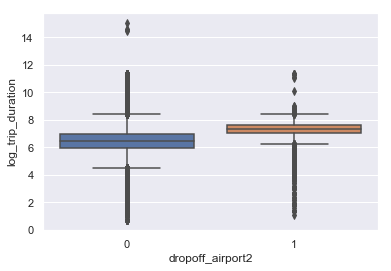

In [116]:
sns.boxplot(data=train, x="dropoff_airport2", y="log_trip_duration")

Судя по графикам, признаки вышли достаточно хороши, особенно те из них, что связаны с аэропортами

**Задание 9**

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin

#class MapGridTransformer(BaseEstimator, TransformerMixin):
    #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 10**

In [121]:
# Добавим в таблицу test новые признаки аналогичные train
test.loc[:, 'haversine'] = haversine_array(
    test['pickup_latitude'].values, 
    test['pickup_longitude'].values, 
    test['dropoff_latitude'].values, 
    test['dropoff_longitude'].values
)
test['log_haversine'] = np.log1p(test.haversine)
test['avg_speed'] = test.haversine/(np.expm1(test.log_trip_duration)/3600)
test['median_speed'] = test.groupby(by=['dayofweek','hour']).avg_speed.transform(lambda s: np.median(s.values))
test['big_traffic'] = (test.median_speed < 10).replace([True, False], [1, 0])
test['free_road'] = (test.median_speed > 20).replace([True, False], [1, 0])
test['pickup_airport1'] = (haversine_array(
    airport1_points[0],airport1_points[1],
    test.pickup_latitude,test.pickup_longitude) < 1).replace([True, False], [1, 0])
test['pickup_airport2'] = (haversine_array(
    airport2_points[0],airport2_points[1],
    test.pickup_latitude,test.pickup_longitude) < 1).replace([True, False], [1, 0])
test['dropoff_airport1'] = (haversine_array(
    airport1_points[0],airport1_points[1],
    test.dropoff_latitude,test.dropoff_longitude) < 1).replace([True, False], [1, 0])
test['dropoff_airport2'] = (haversine_array(
    airport2_points[0],airport2_points[1],
    test.dropoff_latitude,test.dropoff_longitude) < 1).replace([True, False], [1, 0])

# Перейдем к обучению
categorical = ['hour','dayofweek','month','anomaly','big_traffic','free_road','pickup_airport1','pickup_airport2','dropoff_airport1','dropoff_airport2']
numeric_features = ['dayofyear','log_haversine']
target = ['log_trip_duration']

X_train = train[categorical+numeric_features]
y_train = train[target]
X_test = test[categorical+numeric_features]
y_test = test[target]

column_transformer = ColumnTransformer([
# One-hot кодирование для категориальных признаков
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical), 
# Масштабирование для числовых
    ('scaling', StandardScaler(), numeric_features) 
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))


Test MSE = 0.2420


## Часть 3. Изучаем оставшиеся признаки
**Задание 11** 

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.
- vendor_id: теоретически, от провайдера может зависит как модель автомобиля, так и расценки, в результате чего длительность поездки может быть различной


- passenger_count: скорее всего, никак не должно отразиться на значении целевой переменной, если только в выбросах


- store_and_fwd_flag: скорее всего, не должно быть значимых различий

In [52]:
# Посчитаем, сколько есть уникальных значений у каждого из этих признаков:
len(train.vendor_id.unique()), \
len(train.passenger_count.unique()), \
len(train.store_and_fwd_flag.unique())

(2, 9, 2)

Видим по 2 уникальных значения для vendor_id и store_and_fwd_flag, а также 9 для passenger_count

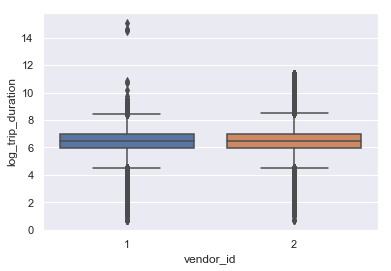

In [53]:
# Построим "ящики с усами" распределений логарифма времени поездки 
# в зависимости от значений каждого из признаков
sns.boxplot(data=train, x="vendor_id", y="log_trip_duration")


В большинстве случаев у первого и второго провайдера наблюдаются идентичные продолжительности поездки, однако у 1го выбросов с более продолжительными поездками мы видим больше

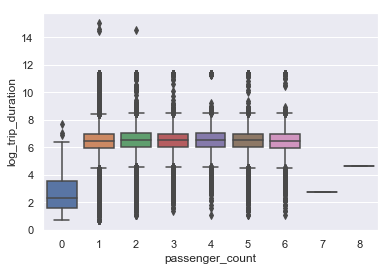

In [54]:
sns.boxplot(data=train, x="passenger_count", y="log_trip_duration")

При нулевом числе пассажиров (доставка?) наблюдаем значимое уменьшение значений целевой переменной

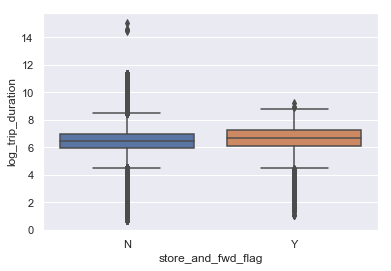

In [130]:
# Y=store and forward; N=not a store and forward trip
sns.boxplot(data=train, x="store_and_fwd_flag", y="log_trip_duration")

In [59]:
len(train[train.store_and_fwd_flag=='N'])/len(train)

0.9944615836638754

В большинстве случаев проблем соединения с сервером не возникало, в результате чего данные автомобиля были бы отправлены поставщику, особенно для длительных расстояний,  а store_and_fwd_flag==True видим у поездок средней продолжительности

In [131]:
# Переведем признаки vendor_id и store_and_fwd_flag в значения {0;1}
train['vendor_id'] = train.vendor_id.replace([1, 2], [1, 0])
train['store_and_fwd_flag'] = train.store_and_fwd_flag.replace(['Y', 'N'], [1, 0])

test['vendor_id'] = test.vendor_id.replace([1, 2], [1, 0])
test['store_and_fwd_flag'] = test.store_and_fwd_flag.replace(['Y', 'N'], [1, 0])


**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

На мой взгляд, число пассажиров может выступить в качестве относительно сильного признака, остальные - нет

**Задание 12** 

In [142]:
# Попробуем обучить модель с добавлением каждого из новых признаков по-отдельности

def comparing_models(new_categorical):
    print('Calculation for the added new_categorical = {}...'.format(str(new_categorical)))
    categorical = ['hour','dayofweek','month','anomaly','big_traffic','free_road','pickup_airport1','pickup_airport2','dropoff_airport1','dropoff_airport2']
    categorical = categorical+new_categorical
    numeric_features = ['dayofyear','log_haversine']
    target = ['log_trip_duration']    

    X_train = train[categorical+numeric_features]
    y_train = train[target]
    X_test = test[categorical+numeric_features]
    y_test = test[target]

    column_transformer = ColumnTransformer([
    # One-hot кодирование для категориальных признаков
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical), 
    # Масштабирование для числовых
        ('scaling', StandardScaler(), numeric_features) 
    ])

    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', Ridge())
    ])

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Test MSE = %.6f" % mean_squared_error(y_test, y_pred))
    
comparing_models([])
comparing_models(['vendor_id'])
comparing_models(['passenger_count'])
comparing_models(['store_and_fwd_flag'])
comparing_models(['vendor_id','passenger_count','store_and_fwd_flag'])


Calculation for the added new_categorical = []...
Test MSE = 0.242021
Calculation for the added new_categorical = ['vendor_id']...
Test MSE = 0.241927
Calculation for the added new_categorical = ['passenger_count']...
Test MSE = 0.241740
Calculation for the added new_categorical = ['store_and_fwd_flag']...
Test MSE = 0.242015
Calculation for the added new_categorical = ['vendor_id', 'passenger_count', 'store_and_fwd_flag']...
Test MSE = 0.241679


Как мы видим, новодобавленные признаки (passenger_count, vendor_id, а store_and_fwd_flag) не дали ощутимого результата (так и не опустились ниже отметки MSE = 24%) - их удалим из данных

In [147]:
train = train.drop(columns = 'passenger_count')
train = train.drop(columns = 'vendor_id')
train = train.drop(columns = 'store_and_fwd_flag')

## Часть 4. Улучшаем модель

**Задание 13**

Text(0.5,1,'Распределение логарифма времени поездки')

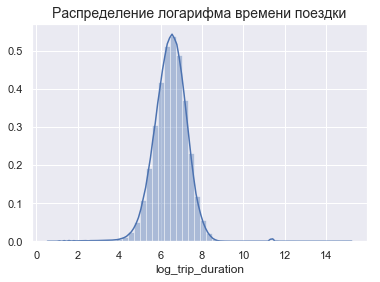

In [168]:
sns.distplot(train.log_trip_duration)
plt.title('Распределение логарифма времени поездки', fontsize = 14)

In [186]:
# Выведем выбросы
print(' Поездки продолжительностью менее', np.expm1(4)/60, 'минут\n', 'Доля таких поездок = ', len(train[train.log_trip_duration<4])/len(train))


 Поездки продолжительностью менее 0.8933025005524039 минут
 Доля таких поездок =  0.005304343567895793


Text(0.5,1,'Распределение логарифма пройденного расстояния')

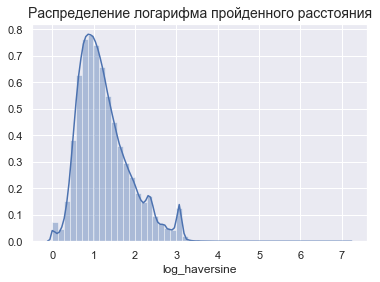

In [169]:
sns.distplot(train.log_haversine)
plt.title('Распределение логарифма пройденного расстояния', fontsize = 14)

In [187]:
# Выведем выбросы
print(' Поездки с расстоянием более', np.expm1(3.5), 'км\n', 'Доля таких поездок = ', len(train[train.log_haversine>3.5])/len(train))


 Поездки с расстоянием более 32.11545195869231 км
 Доля таких поездок =  0.00030262964595269574


Train MSE = 0.2435


Text(0.5,1,'Распределение остатков регрессии')

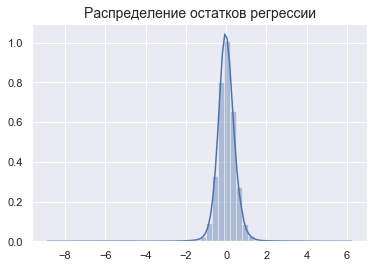

In [191]:
y_train_pred = model.predict(X_train)
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))

sns.distplot(y_train_pred - y_train)
plt.title('Распределение остатков регрессии', fontsize = 14)

In [215]:
# Выведем выбросы
print(' Поездки с модулем остатков более 2\n', 'Доля таких поездок = ', len(train[abs(y_train_pred - y_train).log_trip_duration>2])/len(train))


 Поездки с модулем остатков более 2
 Доля таких поездок =  0.005296508496155918


In [217]:
# Каждый из выбросов не превышает 1го процента от нашей выборки
# Перейдем к их непосредственному удалению из обучающей выборки:
train = train[train.log_trip_duration > 4]
train = train[train.log_haversine < 3.5]
train = train[abs(y_train_pred - y_train).log_trip_duration < 2]

In [223]:
# Посчитаем промежуточный результат:
comparing_models([])

Calculation for the added new_categorical = []...
Test MSE = 0.242557


Попробуем найти редкие категории из наших категориальных признаков, которые было бы допустимо объединить в одну

In [238]:
train[['id','hour']].groupby(by='hour').count()/len(train)

,id
hour,
0,0.036552
1,0.026489
2,0.019005
3,0.014208
4,0.010739
5,0.010106
6,0.022614
7,0.038175
8,0.046079


In [277]:
# Попробуем часть ночного времени со схожими характеристиками на хитмапе
#  свести к одним величинам:
def time_of_day(x):
    if x >= 0 and x <= 1:
        return 0
    elif x >= 2 and x <= 5:
        return 1
    elif x >= 6 and x <= 7:
        return 2
    else:
        return x
    
train['hour_feature'] = train['hour'].apply(lambda x :time_of_day(x))


In [278]:
test['hour_feature'] = test['hour'].apply(lambda x :time_of_day(x))

# Попробуем обучить модель с обновленным признаком
def comparing_models2(categoricals):
    print('Calculation for categoricals = {}...'.format(str(categoricals)))
    numeric_features = ['dayofyear','log_haversine']
    target = ['log_trip_duration']    

    X_train = train[categoricals+numeric_features]
    y_train = train[target]
    X_test = test[categoricals+numeric_features]
    y_test = test[target]

    column_transformer = ColumnTransformer([
    # One-hot кодирование для категориальных признаков
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categoricals), 
    # Масштабирование для числовых
        ('scaling', StandardScaler(), numeric_features) 
    ])

    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', Ridge())
    ])

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Test MSE = %.6f" % mean_squared_error(y_test, y_pred))

basic_categorical = ['hour','dayofweek','month','anomaly','big_traffic','free_road','pickup_airport1','pickup_airport2','dropoff_airport1','dropoff_airport2']
comparing_models2(basic_categorical)
comparing_models2(['hour_feature','dayofweek','month','anomaly','big_traffic','free_road','pickup_airport1','pickup_airport2','dropoff_airport1','dropoff_airport2'])


Calculation for categoricals = ['hour', 'dayofweek', 'month', 'anomaly', 'big_traffic', 'free_road', 'pickup_airport1', 'pickup_airport2', 'dropoff_airport1', 'dropoff_airport2']...
Test MSE = 0.242557
Calculation for categoricals = ['hour_feature', 'dayofweek', 'month', 'anomaly', 'big_traffic', 'free_road', 'pickup_airport1', 'pickup_airport2', 'dropoff_airport1', 'dropoff_airport2']...
Test MSE = 0.243388


Хорошо, результат особо не изменился, зато минимизируем возможность в дальнейшем переобучиться

In [231]:
train[['id','anomaly']].groupby(by='anomaly').count()/len(train)

,id
anomaly,
0,0.992752
1,0.007248


In [264]:
# Попробуем запустить без признака 'anomaly'
comparing_models2(basic_categorical)
comparing_models2(['hour','dayofweek','month','big_traffic','free_road','pickup_airport1','pickup_airport2','dropoff_airport1','dropoff_airport2'])


Calculation for categoricals = ['hour', 'dayofweek', 'month', 'anomaly', 'big_traffic', 'free_road', 'pickup_airport1', 'pickup_airport2', 'dropoff_airport1', 'dropoff_airport2']...
Test MSE = 0.242557
Calculation for categoricals = ['hour', 'dayofweek', 'month', 'big_traffic', 'free_road', 'pickup_airport1', 'pickup_airport2', 'dropoff_airport1', 'dropoff_airport2']...
Test MSE = 0.242594


Модель не улучшилась, но и особых отличий в результате мы не увидели - в дальнейшем удалим этот признак из рассмотрения

In [232]:
train[['id','big_traffic']].groupby(by='big_traffic').count()/len(train)

,id
big_traffic,
0,0.839149
1,0.160851


In [233]:
train[['id','free_road']].groupby(by='free_road').count()/len(train)

,id
free_road,
0,0.96637
1,0.03363


In [265]:
# Попробуем запустить без признака 'free_road'
comparing_models2(basic_categorical)
comparing_models2(['hour','dayofweek','month','big_traffic','pickup_airport1','pickup_airport2','dropoff_airport1','dropoff_airport2']).replace(['Y', 'N'], [1, 0])


Calculation for categoricals = ['hour', 'dayofweek', 'month', 'anomaly', 'big_traffic', 'free_road', 'pickup_airport1', 'pickup_airport2', 'dropoff_airport1', 'dropoff_airport2']...
Test MSE = 0.242557
Calculation for categoricals = ['hour', 'dayofweek', 'month', 'big_traffic', 'pickup_airport1', 'pickup_airport2', 'dropoff_airport1', 'dropoff_airport2']...
Test MSE = 0.243196


Модель не улучшилась, но особых отличий в результате мы не увидели - в дальнейшем вообще удалим этот признак из рассмотрения

In [276]:
# Попробуем объединить признаки pickup_airport1 и dropoff_airport1 в один
train['airport1'] = ((train.pickup_airport1==1)|(train.dropoff_airport1==1)).replace([True, False], [1, 0])
train['airport2'] = ((train.pickup_airport2==1)|(train.dropoff_airport2==1)).replace([True, False], [1, 0])

test['airport1'] = ((test.pickup_airport1==1)|(test.dropoff_airport1==1)).replace([True, False], [1, 0])
test['airport2'] = ((test.pickup_airport2==1)|(test.dropoff_airport2==1)).replace([True, False], [1, 0])

comparing_models2(['hour','dayofweek','month','big_traffic','airport1','pickup_airport2','dropoff_airport2'])
comparing_models2(['hour','dayofweek','month','big_traffic','airport2','pickup_airport1','dropoff_airport1'])
comparing_models2(['hour','dayofweek','month','big_traffic','airport1','airport2'])


Calculation for categoricals = ['hour', 'dayofweek', 'month', 'big_traffic', 'airport1', 'pickup_airport2', 'dropoff_airport2']...
Test MSE = 0.243825
Calculation for categoricals = ['hour', 'dayofweek', 'month', 'big_traffic', 'airport2', 'pickup_airport1', 'dropoff_airport1']...
Test MSE = 0.243196
Calculation for categoricals = ['hour', 'dayofweek', 'month', 'big_traffic', 'airport1', 'airport2']...
Test MSE = 0.243839


Отлично, метрика особо не изменилась, зато мы минимизируем риск переобучиться

In [280]:
# Сведем полученные результаты и посчитаем обновленную модель:
actual_categoricals = ['hour_feature','dayofweek','month','big_traffic','airport1','airport2']
comparing_models2(actual_categoricals)


Calculation for categoricals = ['hour_feature', 'dayofweek', 'month', 'big_traffic', 'airport1', 'airport2']...
Test MSE = 0.245063


**Задание 14** (1 балл). После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.


In [292]:
# Посчитаем колиество признаков до и после кодирования категориальных признаков:
print('До кодирования:',len(actual_categoricals))

pd.DataFrame(OneHotEncoder(sparse=False).fit_transform(train[actual_categoricals]))

До кодирования: 6


,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1012645,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1012646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1012647,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


Как мы видим, число признаков возросло на 32

In [298]:
# Попробуем обучить не Ridge-, а Lasso-регрессию
from sklearn.linear_model import Lasso

X_train = train[actual_categoricals+numeric_features]
X_test = test[actual_categoricals+numeric_features]

column_transformer = ColumnTransformer([
# One-hot кодирование для категориальных признаков
    ('ohe', OneHotEncoder(handle_unknown="ignore"), actual_categoricals), 
# Масштабирование для числовых
    ('scaling', StandardScaler(), numeric_features) 
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = pipeline.fit(X_train, y_train)
model2 = lasso_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred2 = model2.predict(X_test)
print("Test MSE (Ridge) = %.6f" % mean_squared_error(y_test, y_pred))
print("Test MSE (Lasso) = %.6f" % mean_squared_error(y_test, y_pred2))

Test MSE (Ridge) = 0.245063
Test MSE (Lasso) = 0.630972


У Ridge-регрессии вышло гораздо лучшее качество

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для Ridge и Lasso, на тестовой выборке измерьте качество лучшей полученной модели.

In [299]:
from sklearn.model_selection import GridSearchCV

train_train, train_validation, = train_test_split(train, test_size=0.2, random_state=10)

Best alpha = 6.9519


Text(0.5,1,'Подбор оптимальных параметров регуляризации для Ridge')

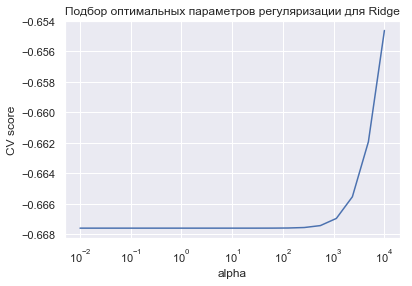

In [316]:
X_train = train_validation[actual_categoricals + numeric_features]
y_train = train_validation[target]
X_test = test[actual_categoricals + numeric_features]
y_test = test[target]

searcher = GridSearchCV(pipeline, [{"regression__alpha": alphas}], cv=10)
searcher.fit(X_train, y_train)

best_alpha2 = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha2)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")
plt.title("Подбор оптимальных параметров регуляризации для Ridge")

Best alpha = 0.0100


Text(0.5,1,'Подбор оптимальных параметров регуляризации для Lasso')

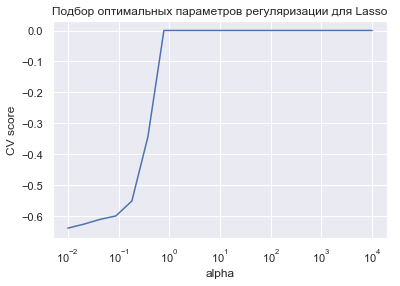

In [319]:
alphas = np.logspace(-2, 4, 20)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}], cv=10)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")
plt.title("Подбор оптимальных параметров регуляризации для Lasso")

In [317]:
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha2))
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train, y_train)
model2 = lasso_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred2 = model2.predict(X_test)
print("Test MSE (Ridge) = %.6f" % mean_squared_error(y_test, y_pred))
print("Test MSE (Lasso) = %.6f" % mean_squared_error(y_test, y_pred2))

Test MSE (Ridge) = 0.245063
Test MSE (Lasso) = 0.262529


У Lasso-регрессии результат значительно улучшился!

Для каждого перебранного alpha для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от alpha. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

Text(0,0.5,'Число нулевых весов')

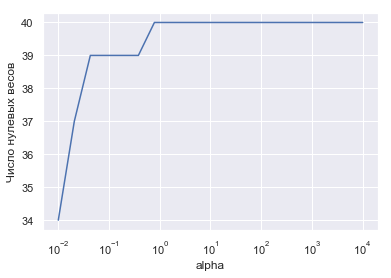

In [370]:
def calc_zeroes(a):
    lasso_pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', Lasso(a))
    ])
    model2 = lasso_pipeline.fit(X_train, y_train)
    return np.sum(lasso_pipeline.steps[-1][-1].coef_ ==0)


plt.plot(alphas, pd.Series(alphas).apply(lambda x :calc_zeroes(x)))
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("Число нулевых весов")

У нас на данном этапе всего 40 признаков (38 категориальных и 2 числовых). Лассо при лучшем альфа уже избавилась от 34х из них